# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
X_train = np.genfromtxt('/content/drive/My Drive/data/train/X_train.txt')
y_train = np.genfromtxt('/content/drive/My Drive/data/train/y_train.txt')

X_test = np.genfromtxt('/content/drive/My Drive/data/test/X_test.txt')
y_test = np.genfromtxt('/content/drive/My Drive/data/test/y_test.txt')

with open('/content/drive/My Drive/data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [6]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING',
 7: 'STAND_TO_SIT',
 8: 'SIT_TO_STAND',
 9: 'SIT_TO_LIE',
 10: 'LIE_TO_SIT',
 11: 'STAND_TO_LIE',
 12: 'LIE_TO_STAND'}

In [7]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7767, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [0]:
try: 
    unique_columns = np.genfromtxt('/content/drive/My Drive/data/unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [0]:
pca = PCA(0.99)

In [0]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [11]:
X_train_pca.shape

(7767, 183)

In [12]:
X_test_pca.shape

(3162, 183)

Text(0, 0.5, 'Principal component 2')

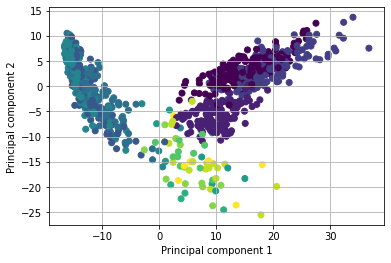

In [13]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

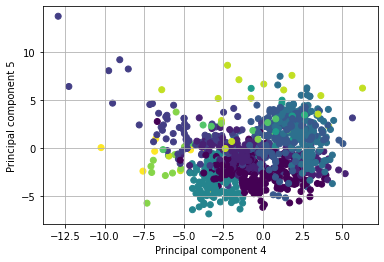

In [14]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

In [16]:
! pip install scikit-plot
! pip install catboost

import scikitplot
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

     |████████████████████████████████| 64.8MB 51kB/s 


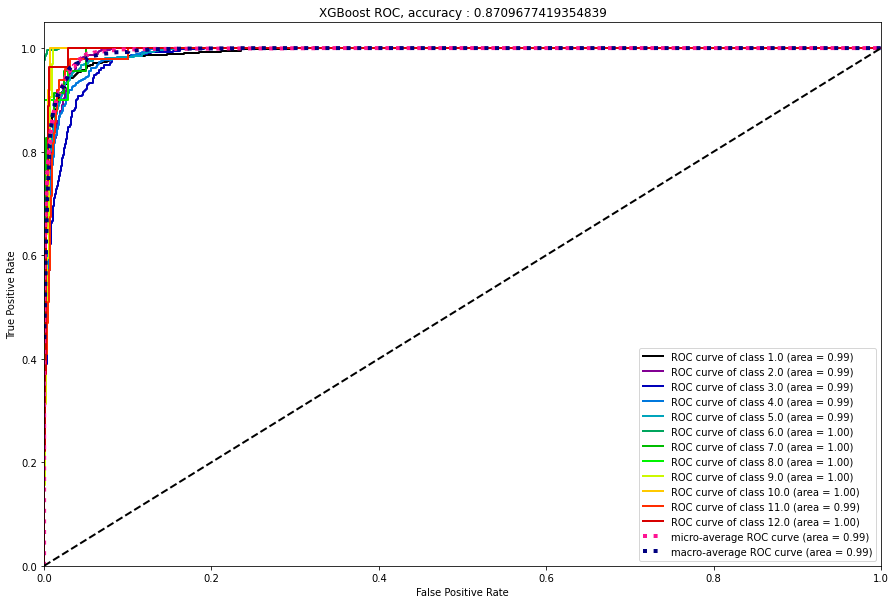

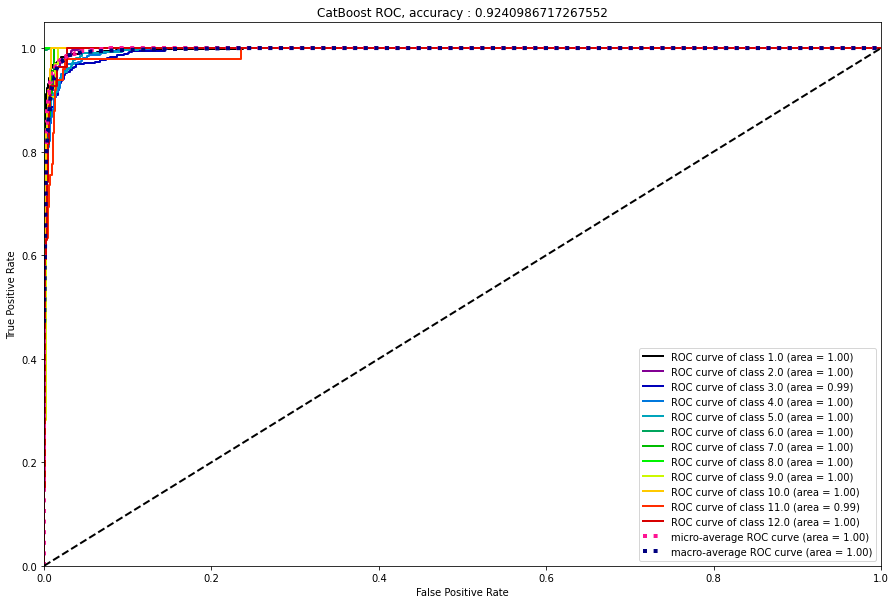

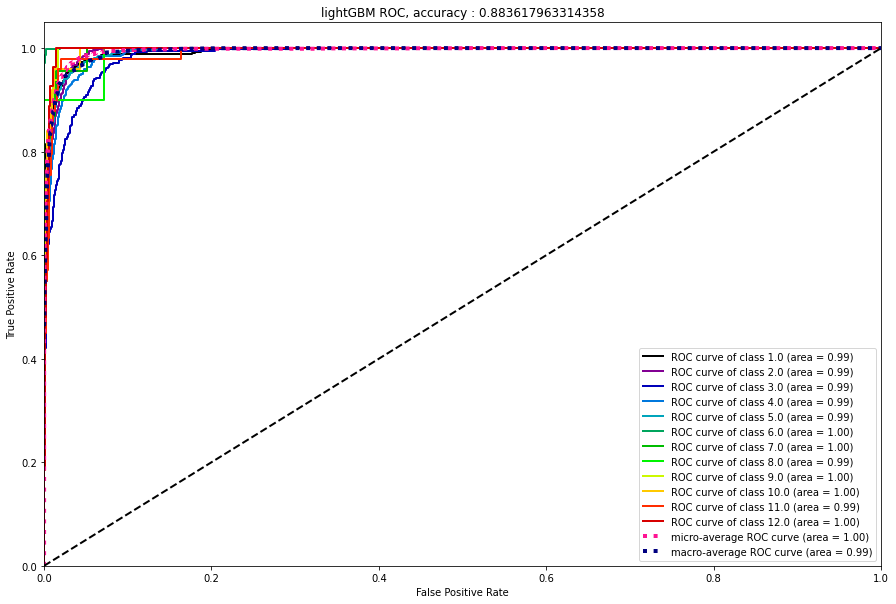

In [25]:
for name, classifier in zip(['XGBoost', 'CatBoost', 'lightGBM'], [XGBClassifier(), CatBoostClassifier(), LGBMClassifier()]):
  classifier.fit(X_train_pca, y_train, verbose=0)
  acc = accuracy_score(y_test, classifier.predict(X_test_pca))
  title = '%s ROC, accuracy : %s' % (name, acc)

  y_probabilities = classifier.predict_proba(X_test_pca)
  scikitplot.metrics.plot_roc(y_test, y_probabilities, title=title, figsize=(15, 10))



Так получилось, что ни с lightgbm, ни с xgboost я не смог получить точности выше 91%, используя grid search.

Ещё я заметил, что у xgboost меньше разброс по accuracy для разных классов в сравнении с lightgbm

C CatBoost сразу получилось добиться точности более 92%.

Из этого следует вывод, что если не особо тюнить модель, то CatBoost подходит лучше, чем альтернативы.

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

In [17]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
models = [LGBMClassifier(), LGBMClassifier(boosting_type='goss'), LGBMClassifier(boosting_type='dart'), XGBClassifier(), LogisticRegression()]

blended_train = pd.DataFrame(X_train_pca)
blended_test = pd.DataFrame(X_test_pca)
blended_y_train = pd.DataFrame(y_train)

for model in models:
  model.fit(X_train_pca, y_train)

  y_predicted = model.predict(X_test_pca)
  print("Accuracy: %s" % str(accuracy_score(y_test, y_predicted)))

  y_predicted = pd.DataFrame(y_predicted)
  blended_train = pd.concat([blended_train, blended_y_train])
  blended_test = pd.concat([blended_test, y_predicted])



Accuracy: 0.883617963314358
Accuracy: 0.8927893738140418
Accuracy: 0.8583175205566097
Accuracy: 0.8709677419354839
Accuracy: 0.9329538266919671


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Получается с помощью блендинга мы смогли переплюнуть Catboost, который утёр нос остальным фраемворкам в предыдущей части. Неточные по-отдельности модели вместе, "сбленденные" дают намного большую точность, что замечательно :)

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

In [18]:
! pip install shap

import shap
shap.initjs()

model = models[0]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_pca)

     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394110 sha256=ea9448157f7f034440379bc6ec9557f0c304b7ff7de3b504ff4192cbbbc1b1c4
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Тут можно посмотреть как дерево делает решение и на каких фичах она это делает.


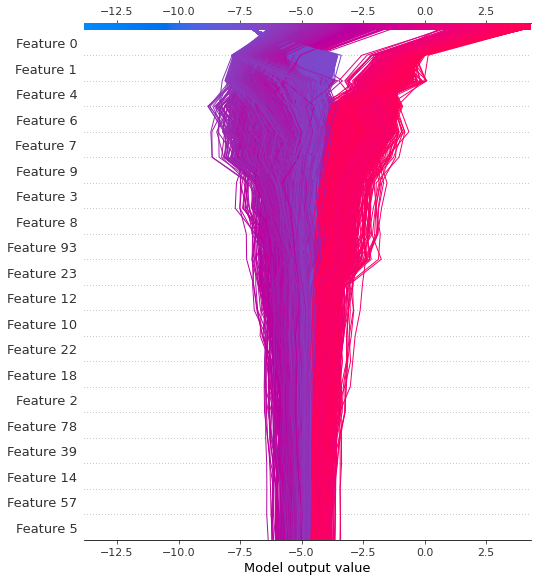

In [0]:
print("Тут можно посмотреть как дерево делает решение и на каких фичах как она это делает.")
shap.decision_plot(explainer.expected_value[0], shap_values[0], X_train_pca, ignore_warnings=True)

На этом графике изображено как нулевая фича повлияла на предсказания модели.


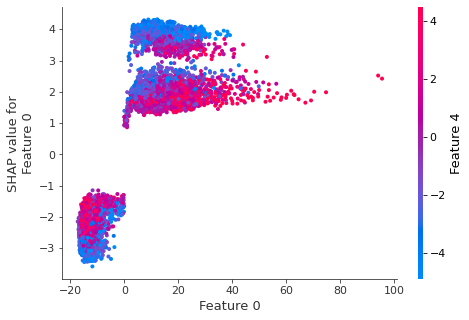

In [19]:
print("На этом графике изображено как нулевая фича повлияла на предсказания модели.")
shap.dependence_plot(0, shap_values[0], X_train_pca) # A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. From docs

Посмотрим насколько много влияния оказывает каждая фича в предсказание того или иного класса. Самый большой столбик = самая важная фича.

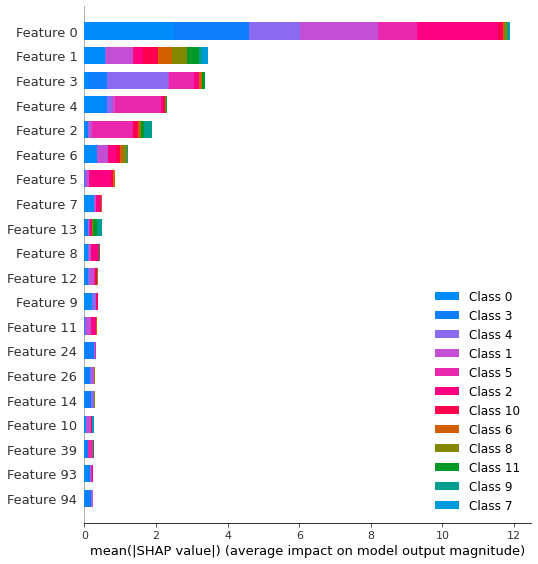

In [20]:
shap.summary_plot(shap_values, X_train_pca)

Та же опция есть в lightgbm, сравним графики, создаваемый shap и "оригинальные"

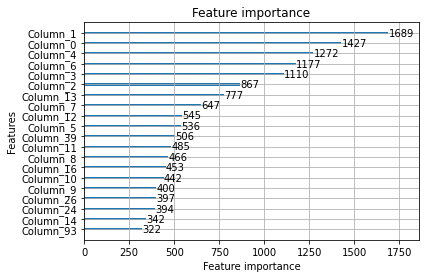

In [24]:
import lightgbm
lightgbm.plot_importance(model, max_num_features=20) # show which features are more important

Как мы видим, shap показывает почти тот же график (но с немного другой оценкой важности конкретной фичи), только красивее и с описанием сколько вклада каждой фичи в предсказание каждого класса.

С помощью shap можно получить много полезной информации о модели, чтобы в последующем оптимизировать своё решение. Например, можно сократить число фич, основываясь на том, какие фичи внесли самый большой эффект в решение. Так же порадовало, что какую бы я модель не выбрал - shap будет работать одинаково для всех вариантов.